## Python Async Programming 异步编程

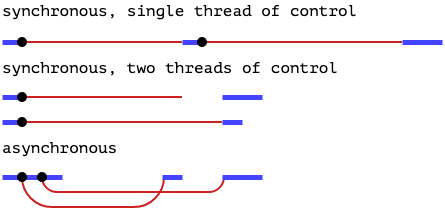

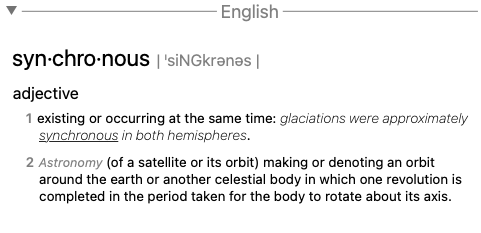

## Python原生的异步编程: 1. 基于yield ; 2. 基于 async

 ### yield 

In [20]:
def gen_numbers(n):
    num = 1
    print('point-01')
    yield n ** num
    
    num += 1
    
    print('point-02')
    yield n ** num
    
    num *= 2
    
    print('point-03')
    yield n ** num    

In [41]:
def yield_to_suspend(a):
    print(f'-> started: a = {a}')
    b = yield a
    
    print(f'-> received b = {b}')
    c = yield a + b

In [38]:
g = yield_to_suspend(1)

In [39]:
next(g)

-> started: a = 1


In [40]:
next(g)

-> received b = 10


In [21]:
g = gen_numbers(10)

In [22]:
next(g)

point-01


10

In [23]:
next(g)

point-02


100

In [24]:
next(g)

point-03


10000

In [78]:
def yield_to_suspend(a):
    print(f'-> started: a = {a}')
    
    a = yield a * 2
    print(f'-> received a = {a}')
    b = -100 
    
    c = yield a + b
    print(f'-> received c = {c}')

In [83]:
g = yield_to_suspend(1)

In [84]:
next(g)

-> started: a = 1


2

In [85]:
g.send(100)

-> received a = 100


0

In [101]:
def average_monitor():
    """
    Give out the increase or decrease of the number
    """
    trend = 'init'
    previous = None
    INC, DEC, EQ = 'Increase', 'Decrease', 'Equal'
    
    while True:
        num = yield trend
        if previous is None:
            previous = num
        else:
            if num > previous: trend = INC
            if num < previous: trend = DEC
            if num == previous: trend = EQ

In [100]:
def average_collect():
    total = 0.0
    count = 0 
    average = None
    
    while True: 
        term = yield average
        total += term 
        count += 1
        average = total  / count

In [104]:
coro_avg = average_collect()
trend = average_monitor()
next(coro_avg)
next(trend)

for _ in range(10):
    num = int(input("please input number"))
    avg = coro_avg.send(num)
    change = trend.send(avg)
    print(change)

please input number10
init
please input number20
Increase
please input number20
Increase
please input number15
Increase
please input number-10
Increase
please input number-100
Decrease
please input number-10
Decrease
please input number10
Decrease


KeyboardInterrupt: 

In [89]:
coro_avg.send(10)

10.0

In [90]:
coro_avg.send(20)

15.0

### 出租车的模拟程序

1. 输入运行的时间
2. 乘客上车、乘客下车 之间来回切换
3. 出租车运行时间的限制

In [133]:
from datetime import datetime, timedelta

In [191]:
s = datetime.strptime('8:06', "%H:%M")

In [159]:
new_d = s + timedelta(minutes=10)

In [160]:
new_d

datetime.datetime(1900, 1, 1, 8, 10)

In [151]:
new_d.strftime("%H:%M")

'08:10'

In [181]:
def taxi_process(total_min, start_time="8:00", indent=0):
    time_format = "%H:%M"

    initial_time = datetime.strptime(start_time, time_format)
    
    event = lambda t, info: f"{'-'*indent} after time: {t.strftime(time_format)}, {info}"

    current_time = initial_time
    t = yield event(current_time, '开始工作')
    
    while (current_time - initial_time).total_seconds() / 60 < total_min:
        current_time += timedelta(minutes=t)
        t = yield event(current_time, '乘客上车')
        current_time += timedelta(minutes=t)
        t = yield event(current_time, '乘客下车')
        
    yield event(current_time, '回家')

In [185]:
import random

In [186]:
taixs = [
    (random.randint(7, 9), random.randint(0, 60), random.randint(3 * 40, 5*60)) for _ in range(5)
]

In [201]:
simulators = []
for i, (h, m, t) in enumerate(taixs):
    simulators.append(
       taxi_process(t, start_time=str(h)+":"+str(m), indent=i)
    )

In [202]:
for s in simulators:
    next(s)

In [203]:
for _ in range(10):
    for s in simulators:
        t = random.randint(5, 120)
        try:
            r = s.send(t)
        except StopIteration:
            pass
        print(r)

 after time: 08:11, 乘客上车
- after time: 09:46, 乘客上车
-- after time: 07:45, 乘客上车
--- after time: 09:44, 乘客上车
---- after time: 08:15, 乘客上车
 after time: 08:39, 乘客下车
- after time: 09:59, 乘客下车
-- after time: 09:14, 乘客下车
--- after time: 11:08, 乘客下车
---- after time: 10:12, 乘客下车
 after time: 10:22, 乘客上车
- after time: 11:42, 乘客上车
-- after time: 10:41, 乘客上车
--- after time: 11:13, 乘客上车
---- after time: 10:12, 回家
 after time: 11:31, 乘客下车
- after time: 11:54, 乘客下车
-- after time: 11:25, 乘客下车
--- after time: 11:21, 乘客下车
--- after time: 11:21, 乘客下车
 after time: 11:56, 乘客上车
- after time: 12:09, 乘客上车
-- after time: 12:44, 乘客上车
--- after time: 11:54, 乘客上车
--- after time: 11:54, 乘客上车
 after time: 12:35, 乘客下车
- after time: 12:29, 乘客下车
-- after time: 13:33, 乘客下车
--- after time: 13:30, 乘客下车
--- after time: 13:30, 乘客下车
 after time: 12:35, 回家
- after time: 12:29, 回家
-- after time: 13:33, 回家
--- after time: 13:30, 回家
--- after time: 13:30, 回家
--- after time: 13:30, 回家
--- after time: 13:30, 回家
--- after time: 13:

In [182]:
taxi = taxi_process(total_min=100)

In [183]:
next(taxi)

' after time: 08:00, 开始工作'

In [184]:
taxi.send(10)

' after time: 08:10, 乘客上车'

In [174]:
taxi.send(15)

'after time: 08:25, 乘客下车'

In [175]:
taxi.send(7)

'after time: 08:32, 乘客上车'

In [176]:
taxi.send(9)

'after time: 08:41, 乘客下车'

In [177]:
taxi.send(15)

'after time: 08:56, 乘客上车'

In [178]:
taxi.send(90)

'after time: 10:26, 乘客下车'

In [179]:
taxi.send(10)

'after time: 10:26, 回家'

## Using Async Keywords

In [226]:
import time

In [230]:
import time
import asyncio


async def f1():
    print('step into f1')
    await asyncio.sleep(0.1)
    # time.sleep(0.1)
    print('execute f1')


async def f2():
    # time.sleep(0.5)
    print('step into f2')
    await asyncio.sleep(0.05)
    print('execute f2')


async def f3():
    # time.sleep(0.001)
    print('step into f3')
    await asyncio.sleep(0.001)
    print('execute f3')


def main():
    f1()
    f2()
    f3()


if __name__ == '__main__':
    loop = asyncio.get_event_loop()
    loop.run_until_complete(asyncio.gather(*[
        f1(),
        f2(),
        f3(),
    ]))
    loop.close()


RuntimeError: This event loop is already running

step into f1
step into f2
step into f3
execute f3
execute f2
execute f1


In [211]:
main()

execut f1
execut f2
execut f3


In [236]:
def generator_n(num):
    for i in range(num):
        yield num ** i

In [239]:
import numpy as np

In [280]:
def simple_generator():
    yield 1
    
    yield 0 
    
    yield -1

def generate_from_generator(num):
    yield from simple_generator()
    
    for n in range(num):
        yield n

In [281]:
g = generate_from_generator(10)

In [282]:
import types

for gi in g:
    print(gi)
#    if isinstance(gi, types.GeneratorType):
#        for x in gi: print(x)
#    else:
#        print(gi)

1
0
-1
0
1
2
3
4
5
6
7
8
9
